In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https:// ### ADD GIT TOKEN ### @github.com/mcembalest/teamBlueConduit.git
%cd teamBlueConduit
!pip install .
!pip install -r requirements.txt > /dev/null
%cd gizmo
!pip install -e .

Cloning into 'teamBlueConduit'...
remote: Enumerating objects: 768, done.
remote: Counting objects: 100% (768/768), done.
remote: Compressing objects: 100% (537/537), done.
remote: Total 768 (delta 380), reused 542 (delta 210), pack-reused 0
Receiving objects: 100% (768/768), 57.44 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/teamBlueConduit
Processing /content/teamBlueConduit
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for BlueConduitSpatial: filename=BlueConduitSpatial-0.0.0-py3-none-any.whl size=66705 sha256=0db0f1705e7189d4891f6ac45f8e986c9909ca4e4bb2c458eb60b98f96fae1a1
  Stored in directory

In [ ]:
!pip install stellargraph

     |████████████████████████████████| 435 kB 4.3 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
black 21.10b0 requires typing-extensions>=3.10.0.0, but you have typing-extensions 3.7.4.3 which is incompatible.


#MAKE SURE TO RESTART KERNEL

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn import preprocessing, feature_extraction, model_selection

import scipy
from scipy.sparse import csr_matrix

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT


###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

# load our data

In [ ]:
data_dir = '/content/drive/MyDrive/AC297r/Data'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'
train_pred_path = f'{pred_dir}/pred_probs_train.npz'
test_pred_path = f'{pred_dir}/pred_probs_test.npz'

Xdata, Ydata, pid, train_idx, test_idx, partitions_builder = load_datasets(load_dir)
train_pred_all, test_pred_all = load_predictions(pred_dir)

In [ ]:
hex_size = 47
train_size = 0.1
split = 0

(train_index, test_index, 
 Xtrain, Xtest, Ytrain, Ytest, 
 train_pred, test_pred, hexagons) = select_data(Xdata, 
                                                Ydata, 
                                                pid, 
                                                train_idx, 
                                                test_idx, 
                                                train_pred_all, 
                                                test_pred_all,
                                                partitions_builder, 
                                                train_size=train_size,
                                                n_hexagons=hex_size,
                                                split=split)

2021-11-03 15:07.24 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 28558.46it/s]

2021-11-03 15:07.26 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-03 15:07.26 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-03 15:07.28 [debug    ] Total parcels after join: 26857
2021-11-03 15:07.28 [info     ] Building the connected graph on the partitions.
2021-11-03 15:07.31 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


In [ ]:
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((2354, 301), (19293, 301), (2354,), (19293,))

In [ ]:
# load distance data
# this part is slow
dis_path = f'{load_dir}/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)

graph = distances['road_distances']
graph[graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0

##Invert distances
invert = lambda x: 1 / (1 + x)
graph = invert(graph)
graph[graph==(1.0)]=0.0

print('graph', graph.shape)

graph (26857, 26857)


# Scale the data

In [ ]:
scaler = StandardScaler()
Xdata_scaled_train = scaler.fit_transform(Xdata.iloc[train_index])
Xdata_scaled_test = scaler.transform(Xdata.iloc[test_index])

Xdata_scaled = Xdata.copy()
Xdata_scaled.iloc[train_index] = Xdata_scaled_train
Xdata_scaled.iloc[test_index] = Xdata_scaled_test
Xdata_scaled

,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,Residential Building Value,Commercial Building Value,Parcel Acres,Year Built,SL_Lead,Ed_July,Ed_March,Max_Lead,Med_Lead,Num_Tests,Res_Test,Sen_Test,B_median_age_all_women,B_median_age_all_men,B_median_age_all,B_median_age_all_women_white,B_median_age_all_men_white,B_median_age_all_white,B_median_age_all_women_black,B_median_age_all_men_black,B_median_age_all_black,B_total_black_pop,B_total_white_pop,B_married_couples,B_single_women,B_married_couples_white,B_single_women_white,B_married_couples_black,B_single_women_black,B_married_couples_w_children,B_single_mothers_w_children,B_households_w_elderly,B_househod_no_elderly,B_aggregate_income,B_speak_spanish,B_speak_only_english,...,CENTRACT_600,CENTRACT_700,CENTRACT_800,CENTRACT_900,CENTRACT_1000,CENTRACT_1100,CENTRACT_1200,CENTRACT_1300,CENTRACT_1400,CENTRACT_1500,CENTRACT_1600,CENTRACT_1700,CENTRACT_1800,CENTRACT_1900,CENTRACT_2000,CENTRACT_2200,CENTRACT_2300,CENTRACT_2400,CENTRACT_2600,CENTRACT_2700,CENTRACT_2800,CENTRACT_2900,CENTRACT_3000,CENTRACT_3100,CENTRACT_3200,CENTRACT_3300,CENTRACT_3400,CENTRACT_3500,CENTRACT_3600,CENTRACT_3700,CENTRACT_3800,CENTRACT_4000,CENTRACT_13500,CENTRACT_13600,CENBLOCK_1,CENBLOCK_2,CENBLOCK_3,CENBLOCK_4,CENBLOCK_5,CENBLOCK_6
0,0.398553,1.224099,-0.554546,-0.132839,-0.290141,-0.043008,-0.023841,-3.800170,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
1,0.398553,0.507317,-0.599385,-0.132839,-0.560610,-0.043008,-1.101734,-3.800170,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
2,-2.540192,-0.774203,-0.583446,-0.132839,-0.668811,-0.043008,-1.089758,0.199707,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
3,-1.070820,-0.280058,-0.567770,-0.132839,-0.684418,-0.043008,-0.670577,-3.800170,-0.272755,-0.080081,-0.080081,-0.036121,1.255974,0.078512,1.280240,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.

# data loaded

# build subgraph

In [ ]:
#n_subgraph = 2000
subgraph_idx = np.array([i for i in range(len(Ydata)) if (i in train_index or i in test_index)])
n_subgraph = len(subgraph_idx)
subgraph = graph[:,subgraph_idx][subgraph_idx,:]
print('subgraph', subgraph.shape, '\n', subgraph)

subgraph (21647, 21647) 
 [[0.         0.02096436 0.02087683 ... 0.         0.         0.        ]
 [0.02710027 0.         0.01398601 ... 0.         0.         0.        ]
 [0.02242152 0.01344086 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.03508772 0.02506266]
 [0.         0.         0.         ... 0.03968254 0.         0.03215434]
 [0.         0.         0.         ... 0.02314815 0.03215434 0.        ]]


# NOTE FROM GRAPHSAGE PAPER
# HELPS TO CUTOFF THE MAX NUM OF EDGES A NODE CAN HAVE
# THEY CUT IT OFF AT 128
# this is taken into account by GraphSAGE sampling neighbors so not too many neighbors are aggregated

# load graph nodes & edges matrices

In [ ]:
train_mask = np.array([1 if i in train_index else 0 for i in range(len(Ydata))])
test_mask = np.array([1 if i in test_index else 0 for i in range(len(Ydata))])

def get_xgboost_prob(idx):
  # idx: the index according to the original 0,...,26856 list
  res = None
  if train_mask[idx]:
    res =  train_pred[np.where(train_index==idx)][0]
  elif test_mask[idx]:
    res = test_pred[np.where(test_index==idx)][0]
  return res

def get_label(idx):
  # idx: the index according to the original 0,...,26856 list
  return Ydata.dangerous.values[idx]
    
def build_feature_matrix(features = None):
  #'features' is a list of named features for use in feature matrix. Example: ['Year Built', 'Land Value', 'Lot Size']
  #Set 'features' to 'All' to get full feature set
  #Leave features as 'None' to just use XGBoost probabilities

  #If no additional features, just use XGBoost probabilities
  if features is None:
    return np.array([[get_xgboost_prob(idx)] for idx in subgraph_idx])

  #Append all features
  elif features == 'All':
    return np.hstack([np.array([get_xgboost_prob(idx) for idx in subgraph_idx]).reshape(-1,1), Xdata_scaled.iloc[subgraph_idx].values])

  #Append selected features
  else:
    return np.hstack([np.array([get_xgboost_prob(idx) for idx in subgraph_idx]).reshape(-1,1), Xdata_scaled[features].iloc[subgraph_idx].values])

train_indices = np.array([idx for idx in subgraph_idx if train_mask[idx]]).astype('int32')
train_labels = np.array([get_label(idx) for idx in subgraph_idx if train_mask[idx]])
test_indices = np.array([idx for idx in subgraph_idx if test_mask[idx]]).astype('int32')
test_labels = np.array([get_label(idx) for idx in subgraph_idx if test_mask[idx]])

#chosen_features = ['Year Built', 'Land Value', 'Parcel Acres', 'Residential Building Value', 'Hydrant Type_A.D.', 'Hydrant Type_Dar', 'Hydrant Type_Mueller', 'Hydrant Type_Other','Hydrant Type_T.C.']
chosen_features = Xdata.columns
fts = build_feature_matrix(features='All').astype('float32')

sparse_subgraph = csr_matrix(subgraph)
row_idx, col_idx, vals = scipy.sparse.find(sparse_subgraph)

# Define graph, namely an edge tensor and a node feature tensor
edges = np.vstack([subgraph_idx[col_idx], subgraph_idx[row_idx]]).T.astype('float32')

print(fts.shape, train_indices.shape, train_labels.shape, test_indices.shape, test_labels.shape, edges.shape)

(21647, 302) (2354,) (2354,) (19293,) (19293,) (8016368, 2)


# prepare StellarGraph data

In [ ]:
flint_train_labels_series = pd.Series(data=train_labels,index=train_indices)
flint_test_labels_series = pd.Series(data=test_labels,index=test_indices)

flint_features = np.append(['XGBoost Prob'], chosen_features)
flint_node_data = pd.DataFrame(
    {f : fts[:,i] for i, f in enumerate(flint_features)}, index=subgraph_idx.astype('int64')
)
flint_edge_data = pd.DataFrame({"source": edges[:,0].astype('int64'), "target": edges[:,1].astype('int64')})
flint_G = sg.StellarGraph(flint_node_data, flint_edge_data)
print(flint_G.info())

StellarGraph: Undirected multigraph
 Nodes: 21647, Edges: 8016368

 Node types:
  default: [21647]
    Features: float32 vector, length 302
    Edge types: default-default->default

 Edge types:
    default-default->default: [8016368]
        Weights: all 1 (default)
        Features: none


In [ ]:
def compare_pred_to_jared(y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(12,6))

    jared_right_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]==np.round(test_pred[i]).astype(int)])
    jared_wrong_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]!=np.round(test_pred[i]).astype(int)])

    axes[0].scatter(test_pred[jared_right_indices], y_pred[jared_right_indices], marker='o', label='Baseline XGBoost correct', alpha=0.1)
    axes[1].scatter(test_pred[jared_wrong_indices], y_pred[jared_wrong_indices], marker='x', s=100, label='Baseline XGBoost incorrect', alpha=0.1)
    axes[0].set_xlabel('Baseline XGBoost model prediction')
    axes[0].set_ylabel('Spatial model prediction')
    axes[0].set_title(f'Comparing XGBoost & Spatial Model\n # XGBoost correct: {len(jared_right_indices)}')
    axes[1].set_xlabel('Baseline XGBoost model prediction')
    axes[1].set_ylabel('Spatial model prediction')
    axes[1].set_title(f'Comparing XGBoost & Spatial Model\n # XGBoost incorrect: {len(jared_wrong_indices)}')
    axes[0].legend()
    axes[1].legend()
    plt.show()

# trying GraphSAGE

In [ ]:
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(flint_train_labels_series)
test_targets = target_encoding.transform(flint_test_labels_series)

batch_size = 512
num_samples = [25, 15]
generator = GraphSAGENodeGenerator(flint_G, batch_size, num_samples)

flint_graphSAGE_train_gen = generator.flow(flint_train_labels_series.index, train_targets)
flint_graphSAGE_test_gen = generator.flow(flint_test_labels_series.index, test_targets)

graphsage_model = GraphSAGE(
  layer_sizes=[64, 64], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

flint_graphSAGE = Model(inputs=x_inp, outputs=prediction)

In [ ]:
flint_graphSAGE.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'), tf.keras.metrics.Precision(name='prec'), tf.keras.metrics.Recall(name='rec'), tf.keras.metrics.TruePositives(name='tp'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.FalsePositives(name='fp'), tf.keras.metrics.FalseNegatives(name='fn') ]
  )
flint_graphSAGE.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 25, 302)]    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 375, 302)]   0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1, 302)]     0                                            
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 1, 25, 302)   0           input_8[0][0]                    
____________________________________________________________________________________________

Epoch 1/100
5/5 - 5s - loss: 0.6599 - acc: 0.5918 - prec: 0.6279 - rec: 0.0549 - tp: 54.0000 - tn: 1339.0000 - fp: 32.0000 - fn: 929.0000
Epoch 2/100
5/5 - 3s - loss: 0.4957 - acc: 0.8029 - prec: 0.7959 - rec: 0.7101 - tp: 698.0000 - tn: 1192.0000 - fp: 179.0000 - fn: 285.0000
Epoch 3/100
5/5 - 3s - loss: 0.4236 - acc: 0.8407 - prec: 0.7852 - rec: 0.8515 - tp: 837.0000 - tn: 1142.0000 - fp: 229.0000 - fn: 146.0000
Epoch 4/100
5/5 - 3s - loss: 0.3837 - acc: 0.8560 - prec: 0.8009 - rec: 0.8718 - tp: 857.0000 - tn: 1158.0000 - fp: 213.0000 - fn: 126.0000
Epoch 5/100
5/5 - 3s - loss: 0.3575 - acc: 0.8636 - prec: 0.8140 - rec: 0.8728 - tp: 858.0000 - tn: 1175.0000 - fp: 196.0000 - fn: 125.0000
Epoch 6/100
5/5 - 3s - loss: 0.3378 - acc: 0.8700 - prec: 0.8296 - rec: 0.8667 - tp: 852.0000 - tn: 1196.0000 - fp: 175.0000 - fn: 131.0000
Epoch 7/100
5/5 - 3s - loss: 0.3202 - acc: 0.8738 - prec: 0.8383 - rec: 0.8647 - tp: 850.0000 - tn: 1207.0000 - fp: 164.0000 - fn: 133.0000
Epoch 8/100
5/5 - 3s -

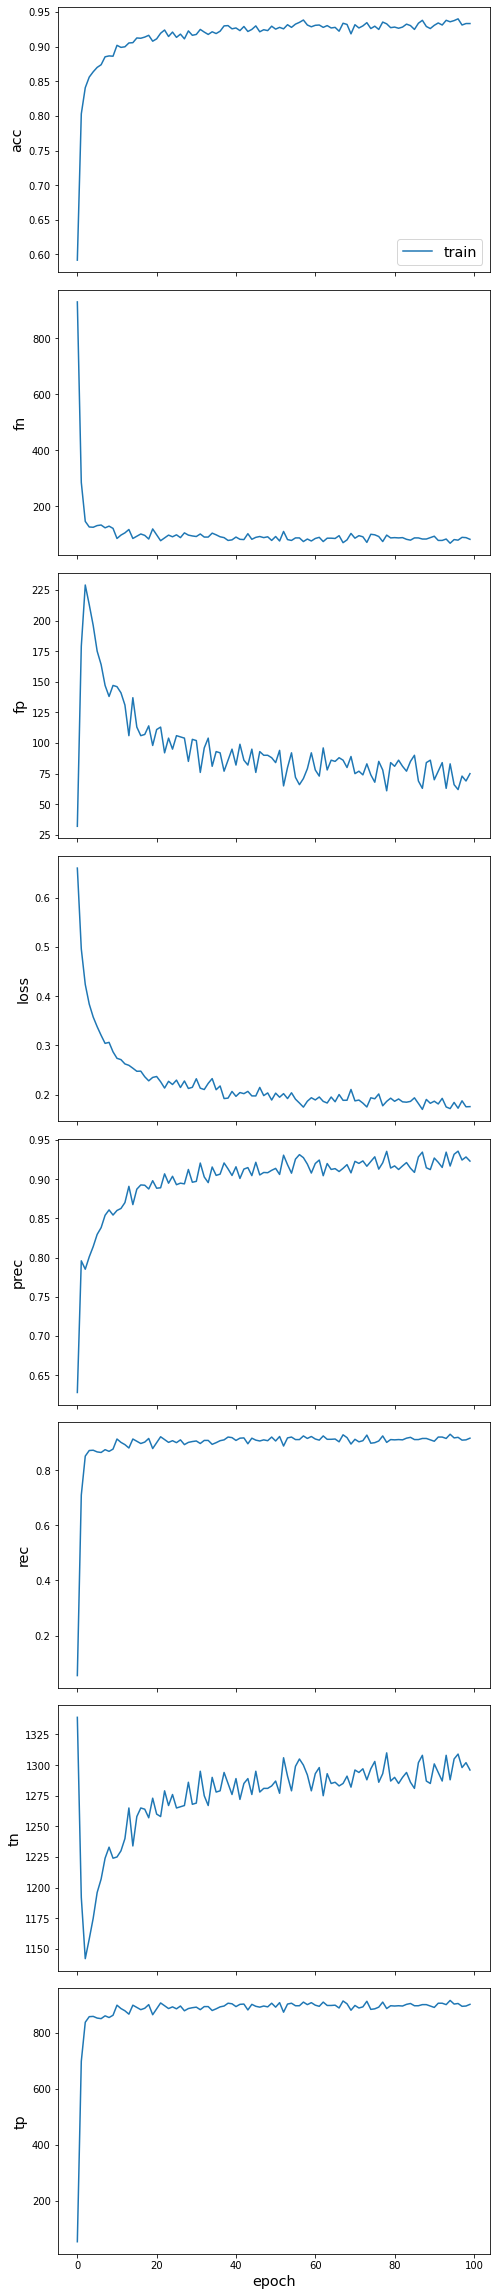

In [ ]:
flint_graphSAGE_history = flint_graphSAGE.fit(
    flint_graphSAGE_train_gen,
    epochs=100,
    verbose=2,
    shuffle=True,
)
flint_graphSAGE_embedding_model = Model(inputs=x_inp, outputs=x_out)
sg.utils.plot_history(flint_graphSAGE_history)

In [ ]:
y_pred_graphSAGE = flint_graphSAGE.predict(flint_graphSAGE_test_gen).flatten()

In [ ]:
mod_train_list = [test_pred, y_pred_graphSAGE]

# threshold_orig = 0.9
# plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'GraphSAGE'], mode='partition', 
#                     parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=threshold_orig)
threshold_init = 0.9
threshold_delta = .1
hrc_xgboost, pred_probs_xgboost = generate_hit_rate_curve_by_partition(hexagons.parcel_gdf, test_index, Ytest, test_pred, threshold_init, threshold_increment=threshold_delta)
hrc_graphsage, pred_probs_graphsage = generate_hit_rate_curve_by_partition(hexagons.parcel_gdf, test_index, Ytest, y_pred_graphSAGE, threshold_init, threshold_increment=threshold_delta)


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


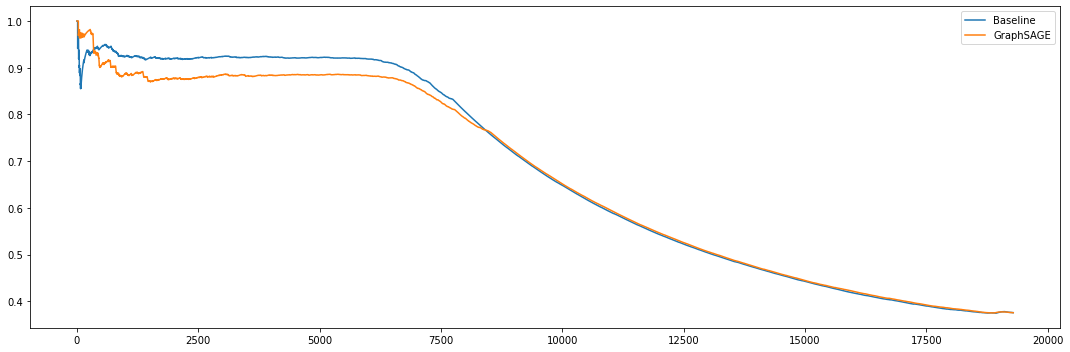

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(len(Ytest)), hrc_xgboost, label='Baseline')
ax.plot(np.arange(len(Ytest)), hrc_graphsage, label='GraphSAGE')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
def eval_tptnfpfn(Ytest, y_pred):
  tp = sum((np.round(y_pred)==Ytest).astype(int)*(Ytest==1.0).astype(int))
  tn = sum((np.round(y_pred)==Ytest).astype(int)*(Ytest==0.0).astype(int))

  fn = sum((np.round(y_pred)!=Ytest).astype(int)*(Ytest==1.0).astype(int))
  fp = sum((np.round(y_pred)!=Ytest).astype(int)*(Ytest==0.0).astype(int))
  return tp, tn, fp, fn
scores_graphSAGE = eval_tptnfpfn(Ytest, y_pred_graphSAGE)
scores_xgboost = eval_tptnfpfn(Ytest, test_pred)
metrics = ['tp', 'tn', 'fp', 'fn']
for i in range(4):
  print(metrics[i])
  print('\t', 'XGBoost: ', scores_xgboost[i])
  print('\t', 'GraphSAGE: ', scores_graphSAGE[i])
print("TP")
print(scores_graphSAGE)
print(scores_xgboost)

tp
	 XGBoost:  6570
	 GraphSAGE:  6387
tn
	 XGBoost:  11124
	 GraphSAGE:  10762
fp
	 XGBoost:  925
	 GraphSAGE:  1287
fn
	 XGBoost:  674
	 GraphSAGE:  857
TP
(6387, 10762, 1287, 857)
(6570, 11124, 925, 674)


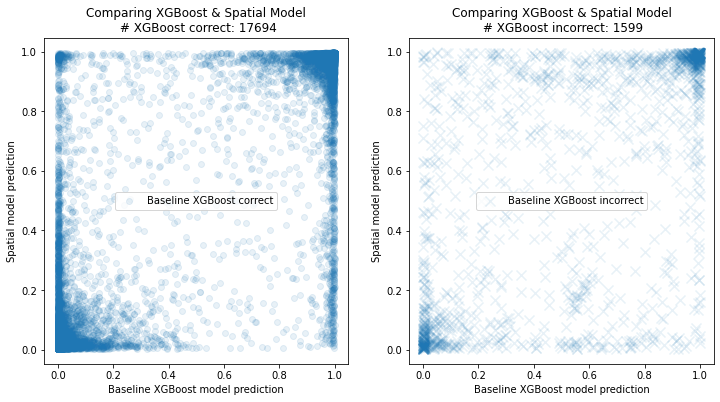

In [ ]:
compare_pred_to_jared(y_pred_graphSAGE)

# save graphSAGE predictions to google drive

In [44]:
with open(pred_dir+'/y_pred_graphSAGE.npy', 'wb') as f:
  np.save(f, y_pred_graphSAGE)

In [45]:
np.load(pred_dir+'/y_pred_graphSAGE.npy')

array([0.9854183 , 0.9891689 , 0.98404217, ..., 0.00306793, 0.00279974,
       0.00289665], dtype=float32)

In [ ]:
def plot_embeddings(embedding_model, gen, label_series):

  from sklearn.manifold import TSNE

  X = embedding_model.predict(gen)
  y = np.argmax(target_encoding.transform(label_series), axis=1)

  trans = TSNE(n_components=2)
  emb_transformed = pd.DataFrame(trans.fit_transform(X), index=label_series.index)
  emb_transformed["label"] = y

  alpha = 0.7

  fig, ax = plt.subplots(figsize=(7, 7))
  ax.scatter(
      emb_transformed[0],
      emb_transformed[1],
      c=emb_transformed["label"].astype("category"),
      cmap="jet",
      alpha=alpha,
  )
  ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

  plt.show()
# plot_embeddings(flint_graphSAGE_embedding_model, flint_graphSAGE_test_gen, flint_test_labels_series)

# define GAT

In [ ]:
def get_GAT_model(G, train_labels, test_labels):

  target_encoding = preprocessing.LabelBinarizer()

  train_targets = target_encoding.fit_transform(train_labels)
  # if train_targets.shape[1]==1:
  #   train_targets = np.column_stack([1 - train_targets, train_targets])

  test_targets = target_encoding.transform(test_labels)
  # if test_targets.shape[1]==1:
  #   test_targets = np.column_stack([1 - test_targets, test_targets])

  generator = FullBatchNodeGenerator(G, method="gat")

  train_gen = generator.flow(train_labels.index, train_targets)
  test_gen = generator.flow(test_labels.index, test_targets)

  gat = GAT(
      layer_sizes=[8, train_targets.shape[1]],
      activations=["elu", "sigmoid"],
      attn_heads=8,
      generator=generator,
      in_dropout=0.5,
      attn_dropout=0.5,
      normalize=None,
  )

  x_inp, predictions = gat.in_out_tensors()

  model = Model(inputs=x_inp, outputs=predictions)

  return model, train_gen, test_gen


In [ ]:
flint_GAT_model, flint_GAT_train_gen, flint_GAT_test_gen = get_GAT_model(flint_G, flint_train_labels_series, flint_test_labels_series)
flint_GAT_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
      loss=tf.keras.losses.binary_crossentropy,
      metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'), tf.keras.metrics.Precision(name='prec'), tf.keras.metrics.Recall(name='rec'), tf.keras.metrics.TruePositives(name='tp'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.FalsePositives(name='fp'), tf.keras.metrics.FalseNegatives(name='fn') ]
  )
flint_GAT_model.summary()

Epoch 1/100
1/1 - 11s - loss: 2.7359 - acc: 0.5251 - prec: 0.4241 - rec: 0.3835 - tp: 377.0000 - tn: 859.0000 - fp: 512.0000 - fn: 606.0000
Epoch 2/100
1/1 - 8s - loss: 2.2267 - acc: 0.5225 - prec: 0.4525 - rec: 0.6836 - tp: 672.0000 - tn: 558.0000 - fp: 813.0000 - fn: 311.0000
Epoch 3/100
1/1 - 8s - loss: 1.6785 - acc: 0.5875 - prec: 0.5043 - rec: 0.7233 - tp: 711.0000 - tn: 672.0000 - fp: 699.0000 - fn: 272.0000
Epoch 4/100
1/1 - 7s - loss: 1.3827 - acc: 0.6308 - prec: 0.5359 - rec: 0.8647 - tp: 850.0000 - tn: 635.0000 - fp: 736.0000 - fn: 133.0000
Epoch 5/100
1/1 - 8s - loss: 1.2781 - acc: 0.6364 - prec: 0.5462 - rec: 0.7630 - tp: 750.0000 - tn: 748.0000 - fp: 623.0000 - fn: 233.0000
Epoch 6/100
1/1 - 7s - loss: 1.0747 - acc: 0.7362 - prec: 0.6893 - rec: 0.6704 - tp: 659.0000 - tn: 1074.0000 - fp: 297.0000 - fn: 324.0000
Epoch 7/100
1/1 - 7s - loss: 0.7416 - acc: 0.7782 - prec: 0.7307 - rec: 0.7426 - tp: 730.0000 - tn: 1102.0000 - fp: 269.0000 - fn: 253.0000
Epoch 8/100
1/1 - 8s - l

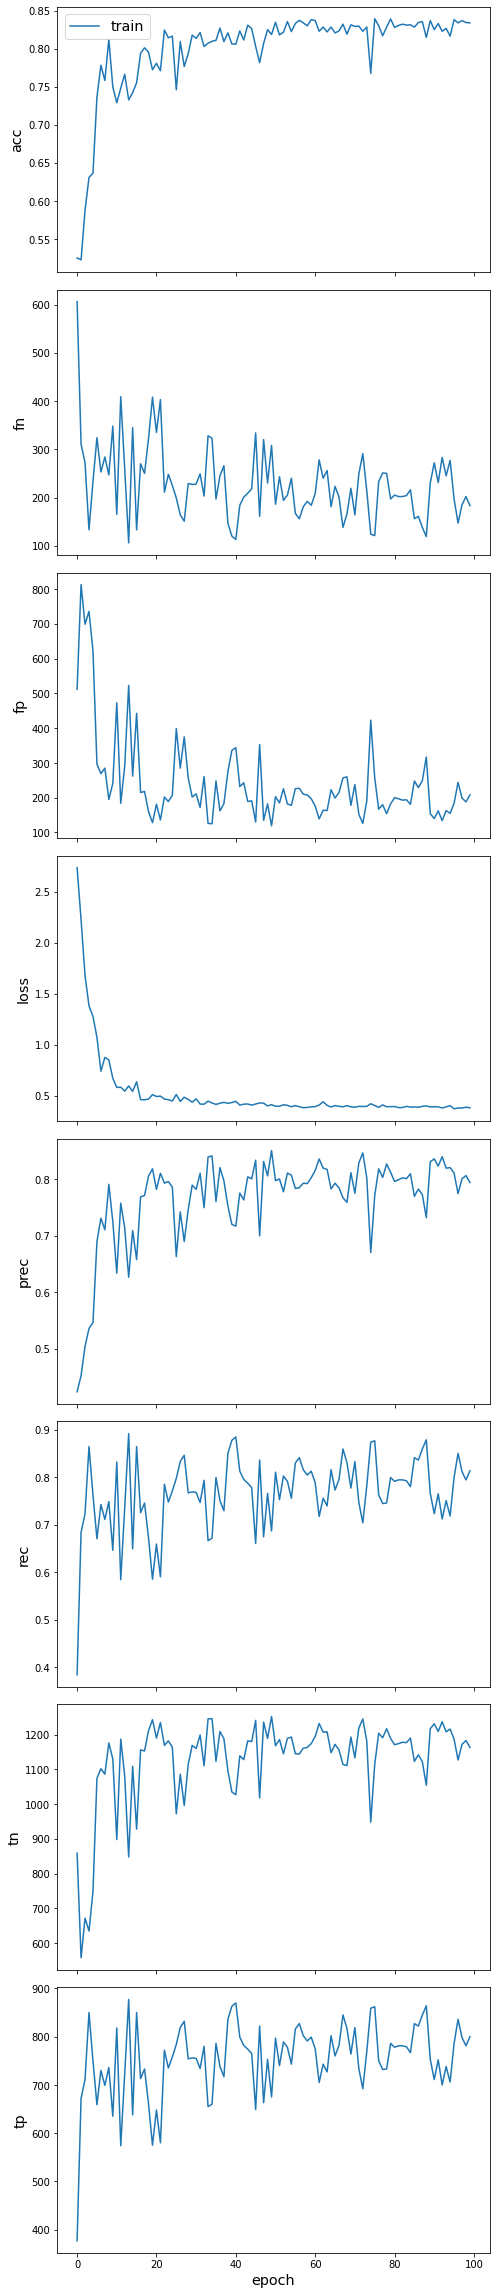

In [ ]:
flint_GAT_history = flint_GAT_model.fit(
    flint_train_gen,
    epochs=100,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
)
sg.utils.plot_history(flint_GAT_history)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/evaluation/evaluate.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dig'] = (df['pred_prob'] > threshold).astype(int)


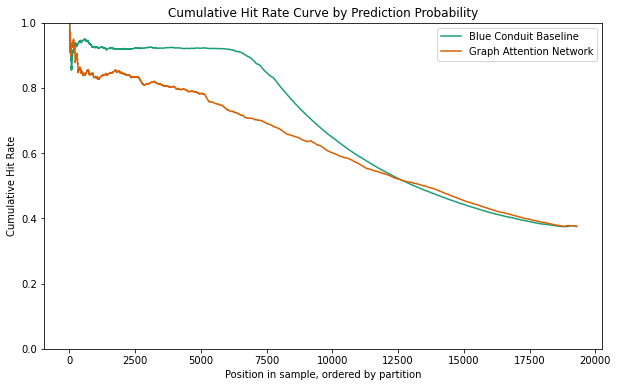

In [ ]:
y_pred_GAT = flint_GAT_model.predict(flint_GAT_test_gen)[0].flatten()#flint_model.predict(flint_test_gen)[0,:,1]
mod_train_list = [test_pred, y_pred_GAT]

threshold_orig = 0.9

plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'Graph Attention Network'], mode='partition', 
                    parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=threshold_orig)


In [ ]:
compare_pred_to_jared(y_pred_GAT)